# Préparation de la base de données #

On importe les packages qui seront nécessaires pour notre analyse de données. 

In [29]:
!pip install pathlib2
!pip install python-Levenshtein
!pip install openpyxl
!pip install --upgrade xlrd
!pip install pandas fiona shapely pyproj rtree
!pip install pyreadr

import requests
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pyreadr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

## Préparation Préliminaire sur R ##

In [ ]:
#Code sur R pour convertir les parties de la base de données qui nous intéressait en fichier csv
"""
#Spécification du chemin

chemin_csv <- "W:/Documents/3A/SocioQ/movie.csv"

# Exporter la base de données en format CSV
write.csv(movies, file = chemin_csv, row.names = FALSE)
"""

## Importation sur Python et création de la base de données d'intérêt ##

On importe la base de donnée qui nous intéresse. Il s'agit de celle convertie précédemment.

In [7]:
encodage = 'latin-1'
try:
    movie = pd.read_csv('movie.csv', encoding=encodage, sep=',')
except pd.errors.ParserError as e:
    print(f"Error reading CSV file: {e}")

/tmp/ipykernel_241/1916420045.py:3: DtypeWarning: Columns (24,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  movie = pd.read_csv('movie.csv', encoding=encodage, sep=',')


On va supprimer les colonnes pas intéressantes dans le cadre de notre analyse pour faciliter l'implémentation. 

In [44]:
df = movie[['url', 'id', 'note_Presse', 'note_Spectateurs', 'Année de production', 'Distributeur','Budget','Langues', 'Récompense']]
df

,url,id,note_Presse,note_Spectateurs,Année de production,Distributeur,Budget,Langues,Récompense
0,https://www.allocine.fr/film/fichefilm_gen_cfi...,304685,"4,0","3,9",2023.0,Gaumont Distribution,-,Français,NaN
1,https://www.allocine.fr/film/fichefilm_gen_cfi...,255726,"4,9","4,3",2022.0,Universal Pictures International France,-,Anglais,NaN
2,https://www.allocine.fr/film/fichefilm_gen_cfi...,287538,"3,5","3,9",2023.0,SND,-,Français,NaN
3,https://www.allocine.fr/film/fichefilm_gen_cfi...,277129,"2,7","3,7",2023.0,Warner Bros. France,-,Anglais,NaN
4,https://www.allocine.fr/film/fichefilm_gen_cfi...,289056,"3,2","4,1",2022.0,ARP Sélection,-,Anglais,NaN
...,...,...,...,...,...,...,...,...,...
102905,https://www.allocine.fr/film/fichefilm_gen_cfi...,261493,NaN,NaN,2018.0,-,-,Anglais,NaN
102906,https://www.allocine.fr/film/fichefilm_gen_cfi...,261515,NaN,NaN,2013.0,-,-,Japonais,NaN
102907,https://www.allocine.fr/film/fichefilm_gen_cfi...,313983,NaN,NaN,2023.0,-,-,Anglais,NaN
102908,https://www.allocine.fr/film/fichefilm_gen_cfi...,314869,NaN,NaN,2024.0,-,-,Anglais,NaN


In [45]:
# Remplacer '--' par NaN et remplacer les virgules par des points dans les colonnes 'note_Presse' et 'note_Spectateurs'
df['note_Presse'] = pd.to_numeric(df['note_Presse'].replace('--', pd.NA).str.replace(',', '.'), errors='coerce')
df['note_Spectateurs'] = pd.to_numeric(df['note_Spectateurs'].replace('--', pd.NA).str.replace(',', '.'), errors='coerce')

/tmp/ipykernel_241/338836235.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['note_Presse'] = pd.to_numeric(df['note_Presse'].replace('--', pd.NA).str.replace(',', '.'), errors='coerce')
/tmp/ipykernel_241/338836235.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['note_Spectateurs'] = pd.to_numeric(df['note_Spectateurs'].replace('--', pd.NA).str.replace(',', '.'), errors='coerce')


In [46]:
df_sans_nan = df.dropna(subset=['note_Presse', 'note_Spectateurs']) #On vire les NaN pour computer la régression

In [47]:
df_sans_nan['Récompense'] = df_sans_nan['Récompense'].notna().astype(int) #Variable binaire pour signifier que le film a été récompensé

/tmp/ipykernel_241/507900940.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sans_nan['Récompense'] = df_sans_nan['Récompense'].notna().astype(int) #Variable binaire pour signifier que le film a été récompensé


In [53]:
df = df_sans_nan

# Traitement des données #

## Statistiques Descriptives ##

In [54]:
#Génération d'un tableau
df.describe()

,id,note_Presse,note_Spectateurs,Année de production,Récompense
count,12647.000000,12647.000000,12647.000000,12643.000000,12647.000000
mean,143700.874753,3.189215,3.040650,2006.453136,0.148652
std,95849.176545,0.718512,0.684756,14.775440,0.355759
min,4.000000,1.000000,0.800000,1921.000000,0.000000
25%,47214.500000,2.700000,2.600000,2002.000000,0.000000
50%,138489.000000,3.200000,3.100000,2009.000000,0.000000
75%,232057.500000,3.600000,3.600000,2016.000000,0.000000
max,311575.000000,5.000000,4.600000,2023.000000,1.000000


### Création de catégories ###

In [56]:
#Création de catégories 

def categorie_note(colonne): 
    #On définit des conditions 
    conditions = [
        (df[str(colonne)] >= 0.0) & (df[str(colonne)]< 0.5),
        (df[str(colonne)] >= 0.5) & (df[str(colonne)] < 1.5),
        (df[str(colonne)]  >= 1.5) & (df[str(colonne)] < 2.5),
        (df[str(colonne)]  >= 2.5) & (df[str(colonne)] < 3.5),
        (df[str(colonne)] >= 3.5) & (df[str(colonne)] < 4.5),
        (df[str(colonne)] >= 4.5)
    ]
    # Définition des catégories correspondantes
    categories = [0, 1, 2, 3, 4, 5]

    # Création de la colonne catégorielle 
    df['Category_' + str(colonne)] = pd.cut(df[str(colonne)], bins=[0, 0.5, 1.5, 2.5, 3.5, 4.5, float('inf')], labels=categories, right=False)
    return df

categorie_note('note_Presse')
categorie_note('note_Spectateurs')

/tmp/ipykernel_241/3411592423.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Category_' + str(colonne)] = pd.cut(df[str(colonne)], bins=[0, 0.5, 1.5, 2.5, 3.5, 4.5, float('inf')], labels=categories, right=False)


,url,id,note_Presse,note_Spectateurs,Année de production,Distributeur,Budget,Langues,Récompense,Category_note_Presse
0,https://www.allocine.fr/film/fichefilm_gen_cfi...,304685,4.0,3.9,2023.0,Gaumont Distribution,-,Français,0,4
1,https://www.allocine.fr/film/fichefilm_gen_cfi...,255726,4.9,4.3,2022.0,Universal Pictures International France,-,Anglais,0,5
2,https://www.allocine.fr/film/fichefilm_gen_cfi...,287538,3.5,3.9,2023.0,SND,-,Français,0,4
3,https://www.allocine.fr/film/fichefilm_gen_cfi...,277129,2.7,3.7,2023.0,Warner Bros. France,-,Anglais,0,3
4,https://www.allocine.fr/film/fichefilm_gen_cfi...,289056,3.2,4.1,2022.0,ARP Sélection,-,Anglais,0,3
...,...,...,...,...,...,...,...,...,...,...
86540,https://www.allocine.fr/film/fichefilm_gen_cfi...,53380,3.3,3.0,2003.0,Swift Distribution,-,-,0,3
87509,https://www.allocine.fr/film/fichefilm_gen_cfi...,8791,3.2,3.0,1996.0,-,-,-,0,3
93873,https://www.allocine.fr/film/fichefilm_gen_cfi...,23127,2.4,2.7,1998.0,-,-,-,0,2
97227,https://www.allocine.fr/film/fichefilm_gen_cfi...,11357,2.6,3.0,1998.0,-,-,-,0,3


### Graphique ### 

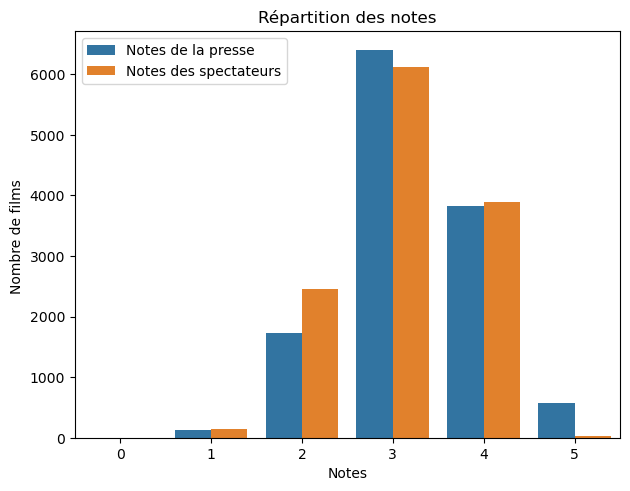

In [67]:
# On combine les catégories
melted_df = pd.melt(df, value_vars=['Category_note_Presse', 'Category_note_Spectateurs'])

# Création d'un graphique
ax = sns.countplot(x='value', hue='variable', data=melted_df)

# Ajout de la légende avec des labels personnalisés
ax.legend(labels=['Notes de la presse', 'Notes des spectateurs'])
plt.tight_layout()
plt.ylabel('Nombre de films ')
plt.xlabel("Notes")
plt.title('Répartition des notes')

#Exportation 
plt.savefig('GraphNotes.png')

# Affichage
plt.show()

## Régressions linéaires ##

                            OLS Regression Results                            
Dep. Variable:       note_Spectateurs   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     4992.
Date:                Fri, 08 Dec 2023   Prob (F-statistic):               0.00
Time:                        10:22:47   Log-Likelihood:                -8477.7
No. Observations:               10117   AIC:                         1.696e+04
Df Residuals:                   10115   BIC:                         1.697e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2913      0.025     50.924      0.0

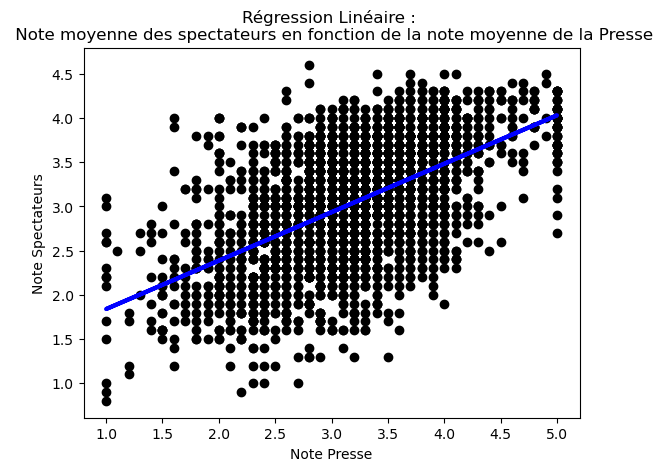

In [22]:
# Sélectionner les colonnes de notes pour la régression linéaire
X = df[['note_Presse']]
y = df['note_Spectateurs']

# Diviser les données en ensembles d'entraînement et de test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imputer pour remplacer les NaN par la moyenne dans les données d'entraînement et de test
imputer_X = SimpleImputer(strategy='mean')
X_train_imputed = imputer_X.fit_transform(X_train)
X_test_imputed = imputer_X.transform(X_test)

# Ajouter une colonne de constantes à X_train_imputed
X_train_imputed = sm.add_constant(X_train_imputed)

# Créer un modèle de régression linéaire avec statsmodels
model = sm.OLS(y_train, X_train_imputed).fit()

# Afficher le résumé du modèle
print(model.summary())

# Effectuer des prédictions sur les données de test
X_test_imputed = sm.add_constant(X_test_imputed)
predictions = model.predict(X_test_imputed)

# Évaluer la performance du modèle
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error : {mse}')
print(f'R-squared : {r2}')

# Tracer la régression linéaire
plt.scatter(X_test, y_test, color='black')  # Utilisez X_test plutôt que X_test_imputed
plt.plot(X_test, predictions, color='blue', linewidth=3)
plt.xlabel('Note Presse')
plt.ylabel('Note Spectateurs')
plt.title('Régression Linéaire : \n Note moyenne des spectateurs en fonction de la note moyenne de la Presse')
plt.show()

                            OLS Regression Results                            
Dep. Variable:            note_Presse   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7169
Date:                Fri, 08 Dec 2023   Prob (F-statistic):              0.397
Time:                        15:51:45   Log-Likelihood:                -10994.
No. Observations:               10117   AIC:                         2.199e+04
Df Residuals:                   10115   BIC:                         2.201e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1935      0.008    413.343      0.0

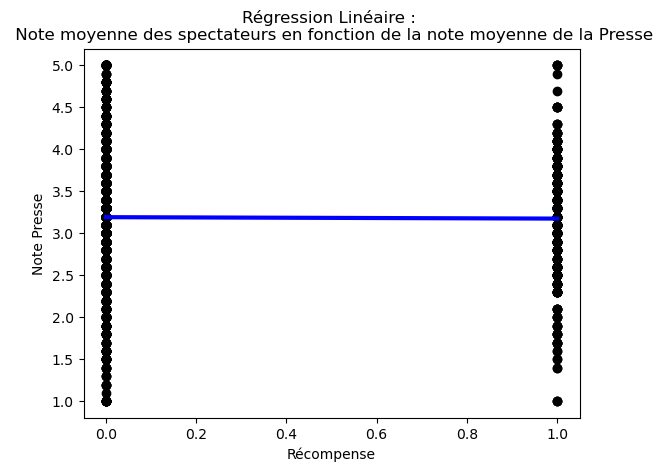

In [70]:
# Sélectionner les colonnes de notes pour la régression linéaire
X = df[['Récompense']]
y = df['note_Presse']

# Diviser les données en ensembles d'entraînement et de test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imputer pour remplacer les NaN par la moyenne dans les données d'entraînement et de test
imputer_X = SimpleImputer(strategy='mean')
X_train_imputed = imputer_X.fit_transform(X_train)
X_test_imputed = imputer_X.transform(X_test)

# Ajouter une colonne de constantes à X_train_imputed
X_train_imputed = sm.add_constant(X_train_imputed)

# Créer un modèle de régression linéaire avec statsmodels
model = sm.OLS(y_train, X_train_imputed).fit()

# Afficher le résumé du modèle
print(model.summary())

# Effectuer des prédictions sur les données de test
X_test_imputed = sm.add_constant(X_test_imputed)
predictions = model.predict(X_test_imputed)

# Évaluer la performance du modèle
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error : {mse}')
print(f'R-squared : {r2}')

# Tracer la régression linéaire
plt.scatter(X_test, y_test, color='black')  # Utilisez X_test plutôt que X_test_imputed
plt.plot(X_test, predictions, color='blue', linewidth=3)
plt.xlabel('Récompense')
plt.ylabel('Note Presse')
plt.title('Régression Linéaire : \n Note moyenne des spectateurs en fonction de la note moyenne de la Presse')
plt.show()

Si on controle par le fait d'avoir reçu une récompense (ce qui peut influencer et la presse et les spectateurs). 

In [73]:
# Sélectionner les colonnes de notes pour la régression linéaire
X = df_sans_nan[['note_Presse', 'Récompense']]
y = df_sans_nan['note_Spectateurs']

# Diviser les données en ensembles d'entraînement et de test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imputer pour remplacer les NaN par la moyenne dans les données d'entraînement et de test
imputer_X = SimpleImputer(strategy='mean')
X_train_imputed = imputer_X.fit_transform(X_train)
X_test_imputed = imputer_X.transform(X_test)

# Ajouter une colonne de constantes à X_train_imputed
X_train_imputed = sm.add_constant(X_train_imputed)

# Créer un modèle de régression linéaire avec statsmodels
model = sm.OLS(y_train, X_train_imputed).fit()

# Afficher le résumé du modèle
print(model.summary())

# Effectuer des prédictions sur les données de test
X_test_imputed = sm.add_constant(X_test_imputed)
predictions = model.predict(X_test_imputed)

# Évaluer la performance du modèle
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error : {mse}')
print(f'R-squared : {r2}')

                            OLS Regression Results                            
Dep. Variable:       note_Spectateurs   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     2497.
Date:                Fri, 08 Dec 2023   Prob (F-statistic):               0.00
Time:                        15:54:31   Log-Likelihood:                -8476.8
No. Observations:               10117   AIC:                         1.696e+04
Df Residuals:                   10114   BIC:                         1.698e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2947      0.025     50.810      0.0